# 1. Metropolis algorithm for the two-dimensional Ising model

Consider the Ising model in a magnetic field:
\begin{equation}
    H = -J \sum\limits_{< ij >}S_i^z S_j^z -h \sum\limits_i S_i^z
\end{equation}
with
\begin{equation}
    \sum\limits_{< ij >} = \frac{1}{2} \sum_i \sum\limits_{j=neighbours(i)}
\end{equation}

## a)

As the metropolis algorithm only depends on the parameter
\begin{equation}
    \alpha = \frac{w(\overline{\{s_l^z\}^k})}{w(\{s_l^z\}^k)} = e^{-\beta \Delta E}
\end{equation}
and therefore on $\Delta E$. (Let $k_B = 1$)

As we only flip one single spin in each cycle of the metropolis algorithm, we can calculate the difference manually:

\begin{align}
    H^{(k)} &= -J \sum\limits_{< ij >}S_i^z S_j^z -h \sum\limits_i S_i^z
\end{align}

The energy after a single spin-flip of the spin with index $i_0$ is given by
\begin{align}
    H^{\overline{(k)}} &= 
        -J \sum\limits_{\begin{smallmatrix}
            < i j > \\ i,j \neq i_0
        \end{smallmatrix}} S_i^z S_j^z 
        -J \sum\limits_{< i_0 j >} (-S_{i_0}^z) S_j^z 
        -h \sum\limits_{i\neq i_0} S_i^z 
        -h (-S_{i_0}^z) \\
    H^{(k)} &= 
        -J \sum\limits_{\begin{smallmatrix}
            < i j > \\ i,j \neq i_0
        \end{smallmatrix}} S_i^z S_j^z 
        -J \sum\limits_{< i_0 j >} S_{i_0}^z S_j^z 
        -h \sum\limits_{i\neq i_0} S_i^z 
        -h S_{i_0}^z \\
    \Rightarrow \underline{\underline{\Delta E}} = H^{\overline{(k)}} - H^{(k)} &=
        -J \sum\limits_{< i_0 j >} (-S_{i_0}^z) S_j^z 
        -h (-S_{i_0}^z)
        +J \sum\limits_{< i_0 j >} S_{i_0}^z S_j^z 
        +h S_{i_0}^z \\
    &= 
        J \sum\limits_{< i_0 j >} S_{i_0}^z S_j^z 
        +h S_{i_0}^z
        +J \sum\limits_{< i_0 j >} S_{i_0}^z S_j^z 
        +h S_{i_0}^z \\
    &= 2J \sum\limits_{< i_0 j >} S_{i_0}^z S_j^z 
        +2h S_{i_0}^z \\
    &= \underline{\underline{
        2J\cdot S_{i_0}^z \sum\limits_{j=n(i_0)} S_j^z 
        +2h S_{i_0}^z }} \\
\end{align}

In [70]:
# global constants
J = +1 # coupling
h = 0 # magnetic field
N = 64 # lattice size
number_configs = 10_000 # number of spin configurations in the Markov chain

10000

In [7]:
# sum over the next neighbours of a given cell (i,j)
@everywhere function get_next_neighbour_sum(spins, i, j)
    n_sum = 0
    # right
    if i < size(spins)[1]
        n_sum += spins[i+1,j]
    else 
        n_sum += spins[1, j]
    end
    
    # left
    if i > 1
        n_sum += spins[i-1,j]
    else
        n_sum += spins[end,j]
    end
    
    # up
    if j < size(spins)[2]
        n_sum += spins[i,j+1]
    else
        n_sum += spins[i,1]
    end
    
    # down
    if j > 1
        n_sum += spins[i,j-1]
    else
        n_sum += spins[i,end]
    end
    
    return n_sum
end

In [73]:
# single iteration step of metropolis (random spin-flip and acceptance/rejection)
# UPDATES the given matrix spins
@everywhere function update_spin_flip!(spins, T, h)
    Nx = size(spins)[1]
    Ny = size(spins)[2]
    
    # random spin flip
    (a,b) = (rand(1:Nx), rand(1:Ny)) # selected cell in lattice
    # energy difference
    ΔE = 2 * J * spins[a, b] * get_next_neighbour_sum(spins, a, b) + 2 * h * spins[a, b]

    α = exp(- ΔE / T) # probability of acceptance
    γ = rand()
    if α ≥ γ
        # accept new configuration
        spins[a, b] *= -1 # flip (a,b)
    else
        # reject new configuration, keep current
    end
end

In [74]:
# generate a Markov chain from Metropolis algorithm
@everywhere function markov_chain(
        spins_start, # start spin configuration
        number_configs, # number of spin configurations in chain
        T, # temperature
        h # magnetic field
    )
    # array to store the random numbers
    spins = []
    push!(spins, spins_start)
    push!(spins, spins_start) #×2
    
    Nx = size(spins_start)[1]
    Ny = size(spins_start)[2]
    
    for i in 1:(number_configs-1)
        # random spin flip
        (a,b) = (rand(1:Nx), rand(1:Ny)) # selected cell in lattice
        ΔE = 2 * J * spins[end][a, b] * get_next_neighbour_sum(spins[end], a, b) + 2 * h * spins[end][a, b]
        
        α = exp(- ΔE / T) # probability of acceptance
        γ = rand()
        if α ≥ γ
            # accept new configuration
            new_spins = copy(spins[end])
            new_spins[a, b] *= -1 # flip (a,b)
            pop!(spins)
            push!(spins, new_spins)
        else
            # reject new configuration, keep current
            #push!(spins, copy(spins[end]))
        end
    end
    return spins
end

In [9]:
# generate a random Nx × Ny spin configuration, in which spin "up" (+1) occurs with probability p
@everywhere function random_start_spins(Nx, Ny, p)
    spins = zeros(Int64, Nx, Ny)
    for i in 1:Nx, j in 1:Ny
        spins[i,j] = (-1)^(rand() > p) # either 1 or -1
    end
    return spins
end

In [10]:
@everywhere begin 
using Colors, Plots
function plot_spin_configuration(spins, Nx, Ny)
    p = heatmap(
        1:1:Nx, # x-axis label
        1:1:Ny,  # y-axis label
        spins, # configuration to plot
        color = reverse(cgrad(:greys)), # reverse the map (0=white, 1=black)
        yflip=true, # t=0 at top
        #size=(800,800), 
        aspect_ratio=:equal,
        legend=false,
        xlabel="x",
        ylabel="y"
    )
    return p
end
end

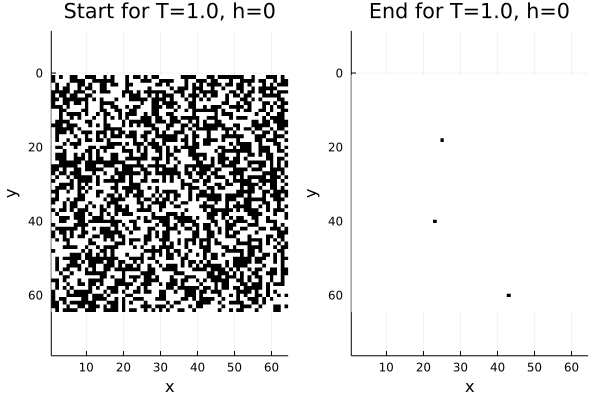

In [11]:
#plot_spin_configuration(random_start_spins(N,N, 0.5), N,N)
T = 1.0
h = 0
J = +1
number_configs = 10_000*N*N
mc = markov_chain(
        random_start_spins(N,N, 0.5), 
        number_configs, # number configs
        T, # T
        h, # h
    );

pstart = plot_spin_configuration(mc[begin], N,N)
title!(pstart, "Start for T=$T, h=$h")
pend = plot_spin_configuration(mc[end], N,N)
title!(pend, "End for T=$T, h=$h")
plot(pstart, pend)

In [614]:
anim = @animate for i in 1:100:number_configs
    plot_spin_configuration(mc[i], N,N)
    title!("T=$T, h=$h, Frame $i")
end

mp4(anim, "1a.mp4", fps=15)

┌ Info: Saved animation to 
│   fn = /Users/felix/sciebo/MSc/2-Primary (SST_CMP)/Computational Many-Body Physics - SoSe 2022 (Core 1)/cmbp22-exercises/sheet_3/1a.mp4
└ @ Plots /Users/felix/.julia/packages/Plots/dNEbX/src/animation.jl:114


Plots.AnimatedGif("/Users/felix/sciebo/MSc/2-Primary (SST_CMP)/Computational Many-Body Physics - SoSe 2022 (Core 1)/cmbp22-exercises/sheet_3/1a.mp4")

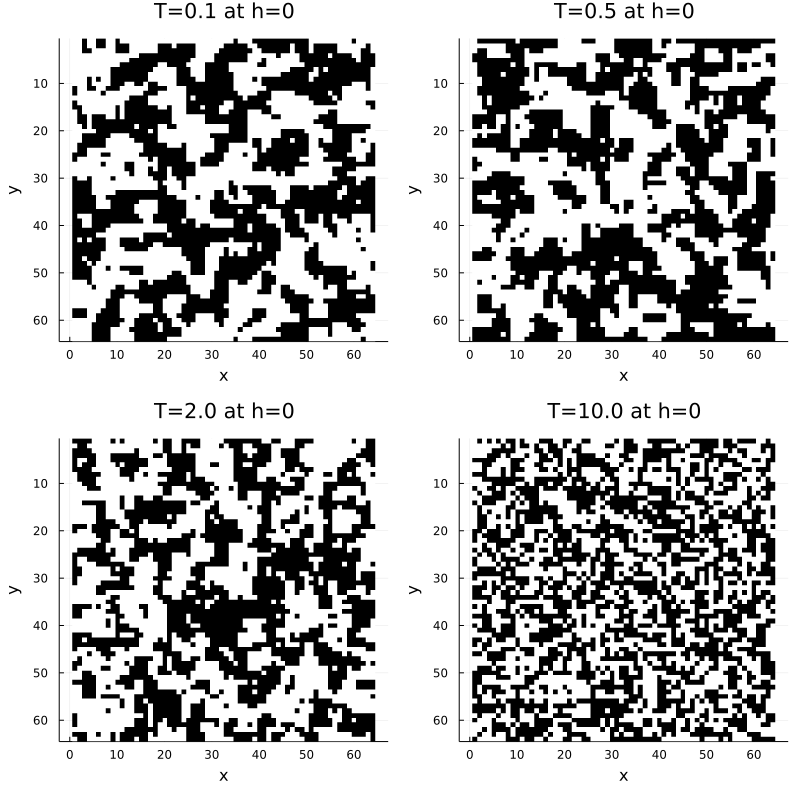

In [79]:
# plotting for different temperatures
Ts = [0.1, 0.5, 2.0, 10.0]
h = 0
ps = []
for T in Ts
    # generate the Markov chain
    mc = markov_chain(
        random_start_spins(N, N, 0.5),
        number_configs,
        T,
        h
    )
    # plot the final configuration
    p = plot_spin_configuration(mc[end], N, N)
    title!(p, "T=$T at h=0")
    push!(ps, p)
end
p1a = plot(ps..., size=(800,800))

In [80]:
savefig(p1a, "1a.png")

## b) Temperature dependence of the magnetization

In [12]:
@everywhere magnetization(spins) = sum(spins)

@everywhere begin
    # global constants
    J = +1 # coupling
    #h = 0 # magnetic field
    N = 64 # lattice size
    number_configs = 10_000 # number of spin configurations in the Markov chain
end

h=0.0 100%|██████████████████████████████████████████████| Time: 0:00:17
h=0.1 100%|██████████████████████████████████████████████| Time: 0:00:17
h=0.2 100%|██████████████████████████████████████████████| Time: 0:00:17
h=0.5 100%|██████████████████████████████████████████████| Time: 0:00:17
h=1.0 100%|██████████████████████████████████████████████| Time: 0:00:17


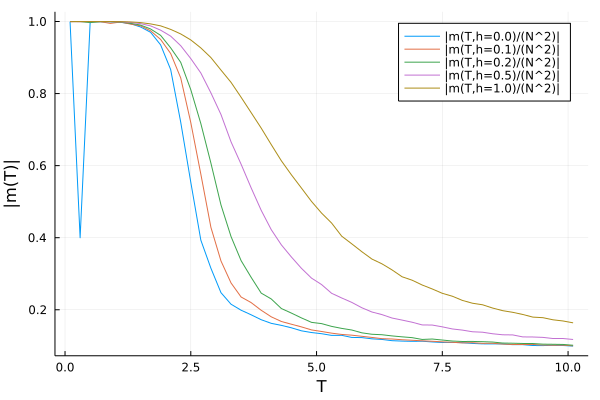

In [85]:
Ts = 0.1:0.2:10.1 #collect(0:0.05:10)
hs = [0, 0.1, 0.2, 0.5, 1.0] #, 0.5, 2.5, 10]
#NUMBER_TRIES = 100 # number of tries per T and h to calculate an average magnetization
N=10
number_configs = 10_000*N*N
p = plot()
xlabel!(p, "T")
ylabel!(p, "|m(T)|")

#@time begin
for h in hs
    ms = []
    @showprogress 1 "h=$h" for T in Ts
        m = 0
        #m = @distributed (+) for i in 1:NUMBER_TRIES
        #    global h = h
        # generate the Markov chain
        spins = random_start_spins(N, N, 0.5)
        m += abs(magnetization(spins))
        
        #@showprogress "h=$h, T=$T" 
        for i in 1:(number_configs-1)
            # make update step
            update_spin_flip!(spins, T, h)
            m += abs(magnetization(spins))
        end
        # calculate the magnetization of the final spin configuration
        m̄ = 1/number_configs * m
        #end
        push!(ms, m̄)
    end
    # plot m(T)
    plot!(Ts, ms/(N*N), label="|m(T,h=$h)/(N^2)|") #, linetype=:scatter, markersize=1)
end
#end
p1b = plot!()

In [86]:
#ms = p[1][1][:y]
#p2 = plot(Ts, abs.(ms))
#p_N64 = p
#p_N64
#p
savefig(p1b, "1b.png")

In [4]:
using ProgressMeter
using Distributed
using Base.Threads
using Hwloc

In [57]:
savefig(p, "1b-NxN.png")

In [5]:
addprocs(Hwloc.num_physical_cores())

6-element Vector{Int64}:
 2
 3
 4
 5
 6
 7

In [608]:
#rmprocs(workers())

In [2]:
workers()

1-element Vector{Int64}:
 1